## Домашнее задание 2. Классификация тональности

В этом задании мы будем решать задачу классификации тональности отзывов о ресторанах. Задачу классификации тональности текста часто решают для автоматизации анализа обратной связи в случаях, когда пользователи не ставят числовую оценку. Например, так можно проанализировать общее настроение комментариев под постом в социальной сети или под видео на видеохостинговой платформе.

В этом задании вам предстоит:

1. Немного предобработать данные.
2. Обучить несколько моделей для задачи классификации и сравнить их между собой:
    1. Наивный Байес
    1. TF-IDF
    1. Сверточную модель

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import re
from nltk.stem import WordNetLemmatizer
from string import punctuation

Начнем с загрузки данных. Мы будем использовать датасет Yelp. Он содержит около 450 тысяч коротких негативных и позитивных отзывов о ресторанах. Это академический датасет, и раньше он часто использовался для тестирования моделей в научных работах.

In [ ]:
train_data = pd.read_csv('yelp_data/yelp_train.csv')
test_data = pd.read_csv('yelp_data/yelp_test.csv')

texts_train = train_data.text
labels_train = train_data.label
texts_test = test_data.text
labels_test = test_data.label

In [3]:
train_data.shape, test_data.shape

((443259, 2), (1000, 2))

In [4]:
texts_train[:5]

0    the service and food is always consistent and ...
1                                      honest people .
2                          it 's all very impressive .
3                              its decor is horrible .
4    definitely will go back to try some of their o...
Name: text, dtype: object

Посмотрим на распределение классов. Для оценки качества можем использовать обычную точность (accuracy), так как классы достаточно сбалансированы.

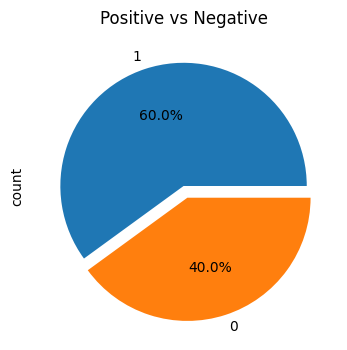

In [5]:
labels_train.value_counts().plot(kind='pie', explode=[0, 0.1], figsize=(4, 4), autopct='%1.1f%%')
plt.title("Positive vs Negative")
plt.show()

## Предобработка данных

Каждый датасет требует индивидуального подхода и предобработка данных зависит от задачи, которую мы решаем. Из стандартных практик для задачи классификации можно выделить _приведение к нижнему регистру_, _лемматизацию_ и _удаление пунктуации_. То есть все то, что почти не меняет содержащуюся информацию. Однако для каждой задачи __обязательно__ надо думать, какую информацию точно нельзя удалять. Например, для этой задачи не стоит удалять стоп-слова (not, no, isn't, always и т.д.), потому что они могут быть важны для классификации тональности. Если у вас нет интуиции о том, какая информация может быть полезна, то __лучше сохранить все__.

__Задание 1.__
Приведите тренировочные и тестовые данные к нижнему регистру, удалите пунктуацию и лемматизуйте. Для проверки запишите обработанный тренировочный корпус в текстовый файл `clean_text_train.txt` в формате обычного текста, в котором тексты отделены переносом строки и сдайте в грейдер.

In [10]:
list(texts_train)[:5]

['the service and food is always consistent and great !',
 'honest people .',
 "it 's all very impressive .",
 'its decor is horrible .',
 'definitely will go back to try some of their other options .']

In [23]:
def remove_punct(texts) -> list:
    pattern_str = '[' + re.escape(punctuation) + ']'
    return [re.sub(pattern=pattern_str, repl='', string=x) for x in texts]

In [24]:
def tokenize(text):
    reg = re.compile(r'\w+')
    return reg.findall(text)

# Применяем функцию токенизации текстов к тренировочной и тестовой выборкам
data_tok_train = [tokenize(t.lower()) for t in remove_punct(texts_train)]
data_tok_test = [tokenize(t.lower()) for t in remove_punct(texts_test)]

In [26]:
def lemmatize_text(tokenized_texts):
    lemmatized_data = []
    lemmatizer = WordNetLemmatizer()
    for words in tqdm(tokenized_texts):
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        lemmatized_data.append(lemmatized_words)
    return lemmatized_data


lemmatized_train = lemmatize_text(data_tok_train)
lemmatized_test = lemmatize_text(data_tok_test)

  0%|          | 0/443259 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
def clean_texts(texts) -> list:
    return [text.lower() for text in texts]

In [12]:
lll = clean_texts(texts_train[:5])

In [13]:
lll

['the service and food is always consistent and great !',
 'honest people .',
 "it 's all very impressive .",
 'its decor is horrible .',
 'definitely will go back to try some of their other options .']

In [15]:
list(texts_train)[:5]

['the service and food is always consistent and great !',
 'honest people .',
 "it 's all very impressive .",
 'its decor is horrible .',
 'definitely will go back to try some of their other options .']

In [28]:
with open('clean_text_train.txt', 'w') as f:
    for text in lemmatized_train:
        f.write(' '.join(text))
        f.write('\n')

In [ ]:
! head clean_text_train.txt

## Метрика

Как уже было сказано, для оценки качества будем считать точность. Загрузим эту метрику из `sklearn`.

In [29]:
from sklearn.metrics import accuracy_score

## Наивный Байес

Наивный байесовский классификатор считает все слова в тексте независимыми и предсказывает класс по формуле
$$
\hat{y} = \underset{y}{\text{argmax}} \, p(y) \prod_{i=1}^n p(x_i | y)
$$
или
$$
\hat{y} = \underset{y}{\text{argmax}} \, p(y) \prod_{w \in V} p(w | y)^{\text{count}(w)}
$$

__Задание 2.__ Обучите Наивный Байес на Bag of Words представлениях текстов. В качестве модели возьмите `MultinomialNB` из `sklearn`. Замерьте точность на тестовой выборке. Если вы все сделали правильно, у вас должно получиться не меньше 0.91.   
Оформите решение в виде функции `train_nb_model`. Она принимает на вход список текстов (список списков слов) и список их меток и возвращает обученную модель `MultinomialNB` вместе с BoW моделью `CountVectorizer`.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

Text(0, 0.5, 'Count')

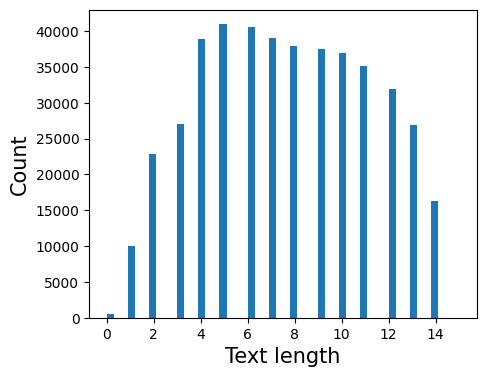

In [31]:
text_lens = [len(x) for x in lemmatized_train]

plt.figure(figsize=(5, 4))
plt.hist(text_lens, bins=50);
plt.xlabel('Text length', size=15)
plt.ylabel('Count', size=15)

In [34]:
lemmatized_train_join = [' '.join(text) for text in lemmatized_train]
lemmatized_test_join = [' '.join(text) for text in lemmatized_test]

In [35]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lemmatized_train_join)
vectorizer.get_feature_names_out()

array(['10', '1000', '1010', ..., 'zoo', 'zucchini', 'zumba'],
      dtype=object)

In [40]:
from typing import List

def train_nb_model(texts: List[List[str]], labels: List[int]) -> (MultinomialNB, CountVectorizer):
    vectorizer = CountVectorizer()
    texts_joined = [' '.join(text) for text in texts]
    X_train = vectorizer.fit_transform(texts_joined)
    mnb = MultinomialNB()
    mnb.fit(X_train,labels)
    return mnb, vectorizer

In [47]:
def train_nb_model(texts_train, labels_train):
    bow = CountVectorizer(
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
    ).fit(texts_train)

    X_train = bow.transform(texts_train)

    model = MultinomialNB().fit(X_train, labels_train)
    return model, bow

In [48]:
mnb, vectorizer = train_nb_model(lemmatized_train, list(labels_train))

/Users/theo/karpov/nlp/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [51]:
lemmatized_test_joined = [' '.join(text) for text in lemmatized_test]
X_test = vectorizer.transform(lemmatized_test)
predicted = mnb.predict(X_test)
# np.mean(predicted == list(labels_test))

In [52]:
np.mean(predicted == list(labels_test))

0.925

## TF-IDF + Логистическая регрессия

Наивный Байес редко работает хорошо, так как он очень чувствителен к редким словам. Гораздо более распространенный и рабочий подход – любой классификатор (логистиченая регрессия, SVM, случайный лес, градиентный бустинг) поверх TF-IDF признаков.

__Задание 3.__ Закодируйте тексты с помощью TF-IDF и обучите на этом логистическую регрессию. Помните, что считать TF-IDF нужно только на обучающей выборке. Удалось ли таким подходом обогнать Наивный Байес?   
В грейдер сдайте код для функции `train_lr_model`. Структура функции аналогична с функции из предыдущего задания. Возвращайте модель и векторизатор.

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [59]:
def train_lr_model(texts, labels) -> (LogisticRegression, TfidfVectorizer):
    bow = TfidfVectorizer(
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
    ).fit(texts)

    X = bow.transform(texts)

    model = LogisticRegression().fit(X, labels)
    return model, bow

In [60]:
mnb, vectorizer = train_lr_model(lemmatized_train, list(labels_train))

/Users/theo/karpov/nlp/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/theo/karpov/nlp/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [58]:
lemmatized_test[:5]

[['the', 'salad', 'are', 'ok', 'nothing', 'special'],
 ['this', 'place', 'ha', 'some', 'great', 'food'],
 ['this',
  'add',
  'the',
  'last',
  'little',
  'touch',
  'to',
  'what',
  'wa',
  'already',
  'an',
  'amazing',
  'place'],
 ['i', 'wa', 'pleased', 'with', 'their', 'service'],
 ['absolutely', 'ridiculous', 'stay', 'away', 'from', 'this', 'place']]

In [61]:
X_test = vectorizer.transform(lemmatized_test)
predicted = mnb.predict(X_test)

In [62]:
np.mean(predicted == list(labels_test))

0.96

## TF-IDF и n-граммы

На данный момент мы вообще не учитываем связи между словами, хотя для нашей задачи они точно важны. Например "хорошо" в сочетании с "не" имеет полностью противоположный смысл, что напрямую влияет на класс. Хотелось бы дать возможность модели получать эту информацию напрямую. Самый популярный на практике способо это сделать – добавить в модель n-граммы слов.

__Задание 4.__ Настройте аргумент `ngram_range` в `TfidfVectorizer` так, чтобы модель учитывала n-граммы. Чем больше n, тем больше признаков получится в итоге. Мы советуем ограничиться 3-граммами и удалить редкие слова (параметр `min_df`), чтобы словарь рос не так быстро.   
Модифицируйте описанным образом функцию `train_lr_model` и сдайте ее код.

In [ ]:
def train_lr_model(texts: List[List[str]], labels: List[int]) -> (LogisticRegression, TfidfVectorizer):
    # ваш код здесь
    pass

## Сверточные нейронные сети

Настало время для тяжелой артиллерии. На данный момент у вас должен был получиться очень хороший бейзлайн, однако его можно улучшить и дальше, например, применив сверточные модели. Важно заметить, что на многих простых задачах классификации TF-IDF и логрег побить не удается, однако в анализе тональности очень важна контекстная информация, которую можно извлечь сверточной сетью.

### Подготовка датасета

Для обучения нейронных сетей нам нужно немного переделать датасет. Во-первых, удалим все редкие слова. При обучении TF-IDF для таких слов автоматически ставился низкий вес. Сверточная сеть же учитывает все слова с одним вестом и редкие слова выучивает гораздо хуже, из-за чего качество может упасть.

__Задание 5.__ Удалите из тренировочного и тестового корпусов все слова, которые встречаются меньше, чем в 15 текстах. Для проверки запишите очищенный тренировочный корпус в текстовый файл `rare_text_train.txt` в формате обычного текста и сдайте в грейдер.   
__Важно:__ список редких слов можно составлять только по обучающей выборке.

In [ ]:
def remove_rare_words(texts) -> list:
    # ваш код здесь
    pass

rare_texts_train = remove_rare_words(texts_train)

with open('rare_text_train.txt', 'w') as f:
    for text in rare_texts_train:
        f.write(' '.join(text))
        f.write('\n')

Нейронная сеть получает на вход индексы слов. Соответственно, нам надо превратить слова в индексы. Удобнее всего для этого использовать `gensim.corpora.dictionary.Dictionary`.

In [ ]:
from gensim.corpora.dictionary import Dictionary

dictionary = Dictionary(texts_train)
dictionary.add_documents([['PAD', 'UNK']])
len(dictionary)

In [ ]:
list(dictionary.token2id.items())[:5]

Соберем датасет из пар (текст, класс), чтобы можно было подать его в `DataLoader`.

In [ ]:
train_dataset = list(zip(texts_train, labels_train))
test_dataset = list(zip(texts_test, labels_test))

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

# Функция для обработки каждого батча
# Добавляем паддинги и превращаем все в тензоры
def collate_fn(batch):
    texts, labels = zip(*batch)
    pad_token_id = dictionary.token2id['PAD']
    unk_token_id = dictionary.token2id['UNK']
    input_ids = [torch.tensor(dictionary.doc2idx(text, unknown_word_index=unk_token_id)) for text in texts]
    return (
        pad_sequence(input_ids, padding_value=pad_token_id).permute(1, 0).to(torch.long),
        torch.tensor(labels)
    )

Наконец, получаем `DataLoader`, из которого мы будем доставать данные.

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=True, batch_size=128)
test_loader = DataLoader(test_dataset, collate_fn=collate_fn, shuffle=False, batch_size=128)

__Задание 6.__ Допишите сверточную сеть на основе 1d сверток. Число слоев и общую архитектуру выберите на ваш вкус. Однако не стройте сразу слишком большую модель, 400 тысяч параметров без слоя эмбеддингов вам точно должно хватить за глаза.

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, hid_dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hid_dim)

        # ваш код здесь

        self.fc = nn.Linear(hid_dim, 1)

    def forward(self, x):
        # ваш код здесь
        pass

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = CNN(vocab_size=len(dictionary), hid_dim=...).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

n_params = sum(torch.numel(p) for p in model.parameters())
n_emb_params = sum(torch.numel(p) for p in model.embedding.parameters())
print(f"Число параметров без эмбеддингов: {n_params - n_emb_params}")

__Задание 7.__ Обучите полученную модель на обработанных данных. Цикл обучения можно взять из семинара, но можно и написать самостоятельно. Советуем для логирования использовать wandb. Примерно 2 эпох должно хватить, чтобы пройти тесты, и 10, чтобы получить качество лучше TF-IDF.

In [ ]:
# ваш код здесь

__ДОПОЛНИТЕЛЬНОЕ ЗАДАНИЕ (НЕ ОЦЕНИВАЕТСЯ)__

Сверточная модель хорошо улавливает контекстную информацию для каждого слова. Однако ее проблема заключается в аггрегировании выхода сверток в один вектор. При суммировании важная информация смешивается с бесполезной, почти то же самое происходит и с max-pooling.   
Для решения этой проблемы добавим подобие механизма внимания. Вместо обычной аггрегации мы применим линейный слой к выходам последней свертки, который выдаст распределение важности каждого вектора. Применим софтмакс к полученным важностям и сложим все векторы с этими весами. Таким образом модель получит возможность самостоятельно выбирать векторы, которые ей важнее сохранить при аггрегации.

\begin{align}
&x \in \mathbb{R}^{n\, \times\, d} – \text{карта признаков (выходы последней свертки)} \\
&Att = \text{softmax}(x \times w + b) \\
&out = \sum_{i=1}^{n} x_i \cdot Att_i
\end{align}

где $w \in \mathbb{R}^{d}, b \in \mathbb{R}$ – обучаемые параметры.

__Задание 8.__ Добавьте описанный слой внимания в вашу модель и обучите ее с теми же параметрами и сравните качество. Возможно, придется немного поколдовать со значением learning rate, но в результате точность должна улучшиться.

In [ ]:
class AttentionCNN(CNN):
    def __init__(self, vocab_size, hid_dim):
        super().__init__(vocab_size, hid_dim)

        # ваш код здесь

    def forward(self, x):
        # ваш код здесь
        pass

In [ ]:
model = AttentionСNN(vocab_size=len(dictionary), hid_dim=...).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
# ваш код здесь

## Резюме

В этом задании мы проделали классическую работу NLP-инженера. Обработали данные подходящим для задачи способом, обучили несколько моделей, начиная с самой простой и постепенно усложняя решение. Скорее всего при обучении сверточной модели вы заметили, что ее качество почти всегда не уступает простому решению через TF-IDF. Если бы мы не начали с простого бейзлайна, то не поняли бы, насколько наша сверточная модель хороша и надо ли ее улучшать.    
В результате вы должны были получить точность около 97%. Для данной задачи – это максимальный результат, его нельзя улучшить почти никакими более сложными моделями, так как тексты короткие и в каждом из них есть слова-маркеры, отвечающие за стиль. Почти любая модель их неплохо извлекает.   
Впрочем, если у вас есть желание, то можно попытаться. :) В таком случае мы советуем начать с анализа текстов, на которых модель ошибается. Может быть они чем-то выделяются?